<a href="https://colab.research.google.com/github/rgnemasters/NBA_2022_Playoff_Predictions/blob/main/NBA_Playoff_Predictor_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [314]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [315]:
#Dataframe and viz libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Models and pipelines
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

#Transformers and imputers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer

#Metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [316]:
df = pd.read_excel('/content/drive/MyDrive/Project Notebooks/Datasets for personal projects/Team_Stat_Table_DateTime.xlsx')
df.head()

,Unnamed: 0,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,playoff_team
0,0,1,San Antonio Spurs,82,19755,3856,7738,0.498,52,206,...,2515,3668,2326,771,333,1589,2103,9788,1980-01-01,True
1,1,2,Los Angeles Lakers,82,19880,3898,7368,0.529,20,100,...,2653,3738,2413,774,546,1639,1784,9438,1980-01-01,True
2,2,3,Cleveland Cavaliers,82,19930,3811,8041,0.474,36,187,...,2381,3688,2108,764,342,1370,1934,9360,1980-01-01,False
3,3,4,New York Knicks,82,19780,3802,7672,0.496,42,191,...,2303,3539,2265,881,457,1613,2168,9344,1980-01-01,False
4,4,5,Boston Celtics,82,19880,3617,7387,0.490,162,422,...,2457,3684,2198,809,308,1539,1974,9303,1980-01-01,True


In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164 entries, 0 to 1163
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    1164 non-null   int64         
 1   Rk            1164 non-null   int64         
 2   Team          1164 non-null   object        
 3   G             1164 non-null   int64         
 4   MP            1164 non-null   int64         
 5   FG            1164 non-null   int64         
 6   FGA           1164 non-null   int64         
 7   FG%           1164 non-null   float64       
 8   3P            1164 non-null   int64         
 9   3PA           1164 non-null   int64         
 10  3P%           1164 non-null   float64       
 11  2P            1164 non-null   int64         
 12  2PA           1164 non-null   int64         
 13  2P%           1164 non-null   float64       
 14  FT            1164 non-null   int64         
 15  FTA           1164 non-null   int64   

In [318]:
df.isna().sum()

Unnamed: 0      0
Rk              0
Team            0
G               0
MP              0
FG              0
FGA             0
FG%             0
3P              0
3PA             0
3P%             0
2P              0
2PA             0
2P%             0
FT              0
FTA             0
FT%             0
ORB             0
DRB             0
TRB             0
AST             0
STL             0
BLK             0
TOV             0
PF              0
PTS             0
Season          0
playoff_team    0
dtype: int64

#Preprocessing

##Data Validation Split

In [319]:
df['playoff_team'] = df['playoff_team'].astype(int)
df.head()

,Unnamed: 0,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,playoff_team
0,0,1,San Antonio Spurs,82,19755,3856,7738,0.498,52,206,...,2515,3668,2326,771,333,1589,2103,9788,1980-01-01,1
1,1,2,Los Angeles Lakers,82,19880,3898,7368,0.529,20,100,...,2653,3738,2413,774,546,1639,1784,9438,1980-01-01,1
2,2,3,Cleveland Cavaliers,82,19930,3811,8041,0.474,36,187,...,2381,3688,2108,764,342,1370,1934,9360,1980-01-01,0
3,3,4,New York Knicks,82,19780,3802,7672,0.496,42,191,...,2303,3539,2265,881,457,1613,2168,9344,1980-01-01,0
4,4,5,Boston Celtics,82,19880,3617,7387,0.490,162,422,...,2457,3684,2198,809,308,1539,1974,9303,1980-01-01,1


In [320]:
df['playoff_team'].value_counts(normalize = True, dropna=False)

1    0.563574
0    0.436426
Name: playoff_team, dtype: float64

In [321]:
#Data split
y = df['playoff_team']
X = df.drop(columns=['Unnamed: 0', 'Season', 'playoff_team'])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, test_size = .3)

##Instantiate and Test Models

In [322]:
#Instantiate OneHotEncoder and ColumnSelector for 'Team' column
#Instantiate Scaler for numeric columns
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [323]:
#Instantiate column transformer
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)
transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

In [324]:
#Instantiate models to test
ada = AdaBoostClassifier()
logreg = LogisticRegression()
lgbm = LGBMClassifier()

In [325]:
#Build model pipelines
ada_pipe = make_pipeline(transformer, ada)
log_pipe = make_pipeline(transformer, logreg)
lgbm_pipe = make_pipeline(transformer, lgbm)

In [326]:
#Instantiate parameter grids for GridCV tuning
ada_params = {'adaboostclassifier__n_estimators': [50, 100, 150, 200],
              'adaboostclassifier__learning_rate': [1, 2]}

logreg_params = {'logisticregression__C': [.01, .1, 1.0, 10, 100, 1000],
                 'logisticregression__penalty': ['l1', 'l2'],
                 'logisticregression__solver': ['liblinear']}
lgbm_params = {'lgbmclassifier__max_depth': range(12, 38, 2),
               'lgbmclassifier__num_leaves': range(20, 40, 5)}

#Instantiate dictionary for looping

model_params = {ada_pipe: ada_params,
               log_pipe: logreg_params,
               lgbm_pipe: lgbm_params}

model_names = ['AdaBoost', 'LogReg', 'LGBM']
results = []
reports = []

In [327]:
def grid_tuner():
  for model, params in model_params.items():
      grid = GridSearchCV(model, params, verbose=1, cv=3, n_jobs=-1, scoring='accuracy')
      grid.fit(Xtrain, ytrain)
      print(grid.best_params_)
      
      ypred_test = grid.predict(Xtest)
      class_report = classification_report(ytest, ypred_test)
      print(class_report)

In [328]:
grid_tuner()

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       159
           1       0.81      0.82      0.82       191

    accuracy                           0.80       350
   macro avg       0.80      0.80      0.80       350
weighted avg       0.80      0.80      0.80       350

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       159
           1       0.85      0.86      0.86       191

    accuracy                           0.85       350
   macro avg       0.84      0.84      0.84       350
weighted avg       0.85      0.85      0.85       350

Fitting 3 folds for each of 52 c

#Model Metrics

In [329]:
#Set up function to evaluate tuned model performance
def model_eval(train_actual = ytrain, test_actual=ytest):
  class_report1 = classification_report(train_actual, train_preds)
  print('***'*20)
  print('Training Set')
  print('***'*20)
  print(class_report1)
  fig, ax = plt.subplots(figsize=(10,8))
  ConfusionMatrixDisplay.from_predictions(train_actual, train_preds, ax = ax)

  class_report2 = classification_report(test_actual, test_preds)
  print('***'*20)
  print('Testing Set')
  print('***'*20)
  print(class_report2)
  fig, ax = plt.subplots(figsize=(10,8))
  ConfusionMatrixDisplay.from_predictions(test_actual, test_preds, ax = ax)

In [330]:
#Instantiate tuned model
log_tuned = LogisticRegression(C=1, random_state=42)
log_pipe = make_pipeline(transformer, log_tuned)
log_pipe.fit(Xtrain, ytrain)

test_preds = log_pipe.predict(Xtest)
train_preds = log_pipe.predict(Xtrain)

************************************************************
Training Set
************************************************************
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       349
           1       0.87      0.90      0.88       465

    accuracy                           0.86       814
   macro avg       0.86      0.86      0.86       814
weighted avg       0.86      0.86      0.86       814

************************************************************
Testing Set
************************************************************
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       159
           1       0.85      0.87      0.86       191

    accuracy                           0.85       350
   macro avg       0.84      0.84      0.84       350
weighted avg       0.85      0.85      0.85       350



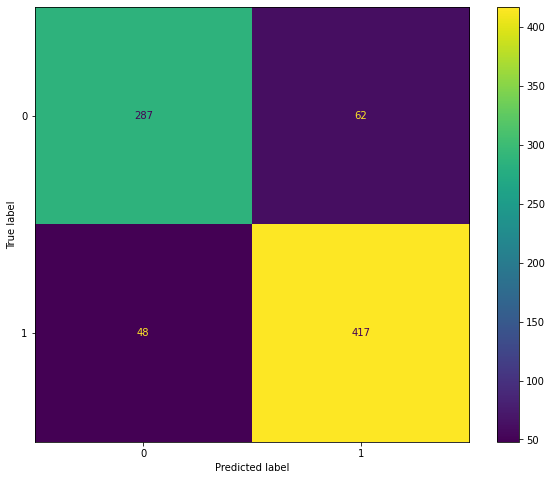

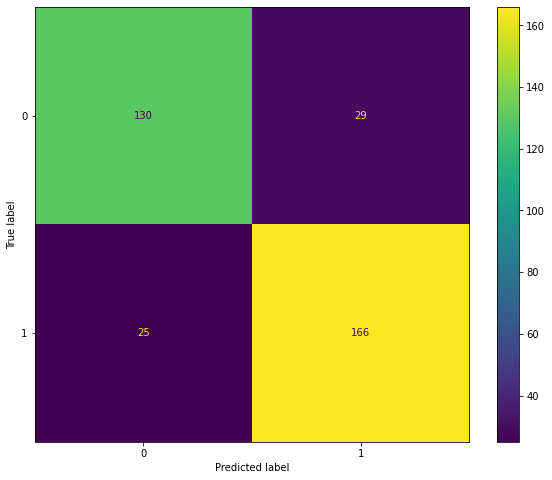

In [331]:
model_eval()

#Scrape Stats for this Year and Test Model Predictions

In [332]:
import requests
from bs4 import BeautifulSoup

In [333]:
#Get webpage to file, parse file

page = requests.get('https://www.basketball-reference.com/leagues/NBA_2022.html')
with open('/content/drive/MyDrive/Project Notebooks/Datasets for personal projects/NBA_2022_Team.html', 'w+') as f:
  f.write(page.text)

In [334]:
with open('/content/drive/MyDrive/Project Notebooks/Datasets for personal projects/NBA_2022_Team.html') as f:
  data = f.read()
  soup = BeautifulSoup(data, 'html.parser')
  table = soup.find(id='per_game-team')
  season_table = pd.read_html(str(table))[0]

In [335]:
season_table.dropna(how='any', inplace=True)
season_table

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1.0,Minnesota Timberwolves,79,241.3,41.6,90.9,0.457,14.8,41.3,0.358,...,0.779,11.3,33.1,44.4,25.6,8.9,5.6,14.4,21.7,115.8
1,2.0,Memphis Grizzlies,78,241.0,43.6,94.3,0.462,11.4,32.5,0.350,...,0.734,14.2,35.2,49.4,25.7,9.8,6.5,13.2,19.6,115.4
2,3.0,Milwaukee Bucks,78,241.0,41.6,89.2,0.466,14.2,38.6,0.367,...,0.773,10.3,36.4,46.7,23.7,7.5,4.0,13.5,18.2,115.0
3,4.0,Phoenix Suns,78,240.6,43.6,89.5,0.487,11.5,31.6,0.365,...,0.798,9.5,35.5,45.0,27.2,8.5,4.4,12.9,19.7,114.9
4,5.0,Charlotte Hornets,78,242.6,42.5,91.6,0.464,13.9,38.3,0.362,...,0.739,10.9,33.7,44.6,27.8,8.7,4.8,13.2,19.9,114.8
5,6.0,Atlanta Hawks,78,240.3,41.4,88.2,0.469,12.8,34.3,0.373,...,0.812,10.0,34.0,44.0,24.5,7.2,4.3,11.9,18.7,113.8
6,7.0,Utah Jazz,78,240.3,40.6,86.1,0.471,14.7,40.5,0.362,...,0.771,10.6,35.3,45.9,22.3,7.1,4.8,14.0,19.0,113.4
7,8.0,San Antonio Spurs,78,241.6,43.4,93.0,0.467,11.3,32.2,0.351,...,0.753,11.2,34.2,45.5,28.0,7.6,5.0,12.8,18.0,113.2
8,9.0,Brooklyn Nets,78,241.0,41.9,88.4,0.474,11.4,31.7,0.361,...,0.801,10.2,33.9,44.2,25.1,7.2,5.4,14.0,20.3,112.5
9,10.0,Denver Nuggets,79,241.3,41.5,86.1,0.483,12.7,35.9,0.355,...,0.795,9.2,34.9,44.0,27.8,7.2,3.7,14.5,19.8,112.4


In [336]:
season_table['Playoff Prediction'] = log_pipe.predict(season_table)

In [337]:
season_table['Playoff Prediction'] = season_table['Playoff Prediction'].astype(bool)

In [338]:
season_table

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Playoff Prediction
0,1.0,Minnesota Timberwolves,79,241.3,41.6,90.9,0.457,14.8,41.3,0.358,...,11.3,33.1,44.4,25.6,8.9,5.6,14.4,21.7,115.8,False
1,2.0,Memphis Grizzlies,78,241.0,43.6,94.3,0.462,11.4,32.5,0.350,...,14.2,35.2,49.4,25.7,9.8,6.5,13.2,19.6,115.4,True
2,3.0,Milwaukee Bucks,78,241.0,41.6,89.2,0.466,14.2,38.6,0.367,...,10.3,36.4,46.7,23.7,7.5,4.0,13.5,18.2,115.0,True
3,4.0,Phoenix Suns,78,240.6,43.6,89.5,0.487,11.5,31.6,0.365,...,9.5,35.5,45.0,27.2,8.5,4.4,12.9,19.7,114.9,True
4,5.0,Charlotte Hornets,78,242.6,42.5,91.6,0.464,13.9,38.3,0.362,...,10.9,33.7,44.6,27.8,8.7,4.8,13.2,19.9,114.8,False
5,6.0,Atlanta Hawks,78,240.3,41.4,88.2,0.469,12.8,34.3,0.373,...,10.0,34.0,44.0,24.5,7.2,4.3,11.9,18.7,113.8,True
6,7.0,Utah Jazz,78,240.3,40.6,86.1,0.471,14.7,40.5,0.362,...,10.6,35.3,45.9,22.3,7.1,4.8,14.0,19.0,113.4,False
7,8.0,San Antonio Spurs,78,241.6,43.4,93.0,0.467,11.3,32.2,0.351,...,11.2,34.2,45.5,28.0,7.6,5.0,12.8,18.0,113.2,True
8,9.0,Brooklyn Nets,78,241.0,41.9,88.4,0.474,11.4,31.7,0.361,...,10.2,33.9,44.2,25.1,7.2,5.4,14.0,20.3,112.5,True
9,10.0,Denver Nuggets,79,241.3,41.5,86.1,0.483,12.7,35.9,0.355,...,9.2,34.9,44.0,27.8,7.2,3.7,14.5,19.8,112.4,True
